# An Exploration of Fluctuating Channel Flow

This is a sandbox for exploring the fluctuating channel flow data. Data is loaded using the YT package. You might need to install (using `pip`):
1. Jupyter (and Jupyter Lab)
2. YT
3. numpy
4. matplotlib

... Have fun!

## Import Basics

In [62]:
import sys, os, os.path
import glob

import scipy as sp
import numpy as np

import matplotlib
import matplotlib.pyplot as pp

import yt
from yt.frontends.boxlib.data_structures import AMReXDataset
yt.funcs.mylog.setLevel(50)

Inline plots and namespace:

In [63]:
%pylab inline
%precision %e

Populating the interactive namespace from numpy and matplotlib


u'%e'

# Utilities

Replace `phi` with `concentration` in plot file's header file (yt doesn't like `phi`...)

In [64]:
### Replace "phi" with "concentration" in plt header file (yt doesn't like phi...)
def substitute_header(plt_file, source="phi", target="con"):
    
    # load header file
    header_file = os.path.join(plt_file, "Header")
    with open(header_file, "r") as f:
        header_orig = f.readlines()
    
    # select variable lables
    n_lables   = int(header_orig[1])
    l_offset   = 2
    
    # make a backup copy(iff the source was found in original)
    if source+"\n" in header_orig:
        header_cpy  = os.path.join(plt_file, "Header.backup")
        with open(header_cpy, "w") as f:
            for line in header_orig:
                f.write(line)
    
    # replace source with target
    for i in range(l_offset, n_lables+l_offset):
        if header_orig[i] == source+"\n":
            header_orig[i] = target+"\n"
    
    # save substituted file in place of original
    with open(header_file, "w") as f:
        for line in header_orig:
            f.write(line)

# Find Data

Currently we're working in the same directory as a the data $=>$ look in `.` for plot files

In [65]:
data_root = "."
data_dir  = "."

In [66]:
data_path = os.path.join(data_root, data_dir)

In [67]:
n_fill   = 5
prefix   = "plt"
file_fmt = prefix + "{:0" + str(n_fill) + "d}"

In [68]:
file_fmt

'plt{:05d}'

In [69]:
data_glob  = os.path.join(data_path, prefix + "*")
data_files = glob.glob(data_glob)
data_files.sort()
print(data_files)

['././plt0000000', '././plt0000100', '././plt0000200', '././plt0000300', '././plt0000400']


In [70]:
len(data_files)

5

## Plot Final State of the Simulation

In [71]:
def plot_index(data_file, str_field, str_coord):
    substitute_header(data_file)
    
    # Loads the data file
    ds = yt.load(data_file)
    
    # Takes a slice perpendicular to the coordinate represented by `str_coord`
    # -> the slice is at the center of the box.
    # -> the data field being sliced has to have the same name as `str_field`
    slc = yt.SlicePlot(ds, str_coord, str_field)
    
    # Set the plotted variable to log scale
    #slc.set_log(str_field, True)
    
    # Show data
    slc.show()
    #slc.save("step_0.png")

Let's find out what fields are contained in the plot file

In [72]:
ds = yt.load(data_files[-1])
ds.field_list
ds.domain_dimensions

array([32, 32, 32])

Plot the last plot file's $y$-velocity (slicing normal the $y$-axis).


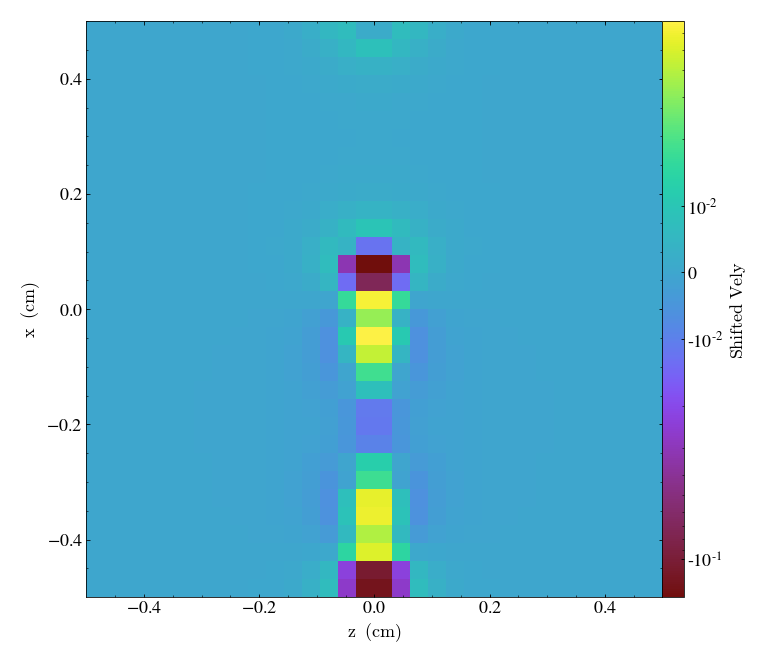

In [73]:
plot_index(data_files[-1], "shifted_vely", "y")

Let's do the same for the presure


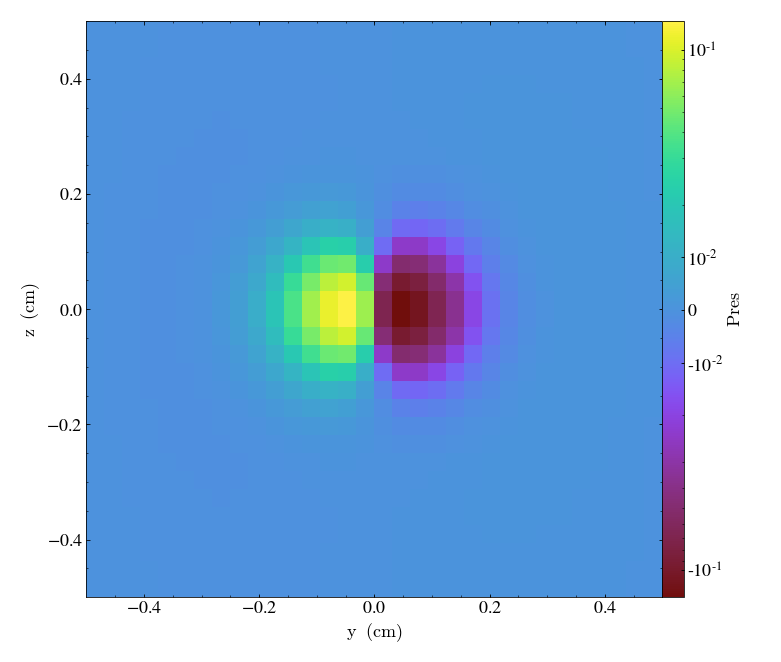

In [74]:
plot_index(data_files[-1], "pres", "x")

# Analyse Data

... with `numpy`

## Velocity fluctuations

In [75]:
ds = yt.load(data_files[-1])

Get information about geometry: $\mathrm{d}x$ and index of centre

In [76]:
dx = np.array(
    [
        ( ds.domain_right_edge[i] - ds.domain_left_edge[i] ) / ds.domain_dimensions[i] 
        for i in range(ds.dimensionality) 
    ]
)


centre_slice = np.array([ei for ei in ds.domain_right_edge ])/2
ind_cen      = centre_slice / dx
print(ind_cen)

[16. 16. 16.]


Extract a "cube of data" from the plot file. This might seem a bit convoluted, but remember that YT is built to handle multi-level data. This function covers a given level (in our case, level 0) with a 3D grid (cube) and exports the data into a dict of `numpy` arrays. This way `cube["filed name"]` is a 3D numpy array.

In [77]:
cube = ds.covering_grid(level=0, fields=["shifted_velx", "shifted_vely", "shifted_velz"], 
                        left_edge=ds.domain_left_edge, dims=ds.domain_dimensions)
velx = cube["shifted_velx"]
vely = cube["shifted_vely"]
velz = cube["shifted_velz"]

Double-check the data.

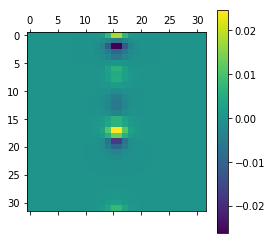

In [78]:
matshow(velx[:, 16, :])
colorbar()

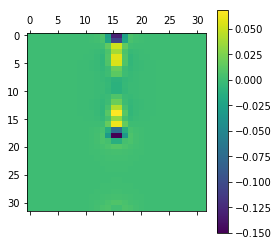

In [79]:
matshow(vely[:, 16, :])
colorbar()

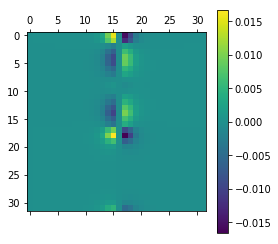

In [80]:
matshow(velz[:, 16, :])
colorbar()

In [81]:
class SoA:
    _pref = "particle_"
    _pos  = "position_"
    _vel  = "vel"
# New here
    _id   = "id"
    _cpu  = "cpu"
    _id_0 = "id_0"
    _cpu_0 = "cpu_0"
    
    def __init__(self, data):
        str_pos = self._pref+self._pos
        self.px = np.array(data[str_pos + "x"])
        self.py = np.array(data[str_pos + "y"])
        self.pz = np.array(data[str_pos + "z"])

        str_vel = self._pref+self._vel
        self.vx = np.array(data[str_vel + "x"])
        self.vy = np.array(data[str_vel + "y"])
        self.vz = np.array(data[str_vel + "z"])

        str_id = self._pref+self._id
        self.id = np.array(data[str_id])
        str_cpu = self._pref+self._cpu
        self.cpu = np.array(data[str_cpu])
        
        str_id_0 = self._pref+self._id_0
        self.id_0 = np.array(data[str_id_0])
        str_cpu_0 = self._pref+self._cpu_0
        self.cpu_0 = np.array(data[str_cpu_0])
 
# new here
    def __str__(self):
        return "{pos:"  + str(self.px) + "," + str(self.py) + "," + str(self.pz) + \
              "; vel:"  + str(self.vx) + "," + str(self.vy) + "," + str(self.vz) + \
              "; id:"   + str(self.id) + ", cpu:" + str(self.cpu) + ", id_0:" + str(self.id_0) + ", cpu_0:" + str(self.cpu_0) + "," + "}"


    def __repr__(self):
        return str(self)


# new here
class Particle:
    def __init__(self, px, py, pz, vx, vy, vz, id, cpu, id_0, cpu_0):
        self.pos = np.array([px, py, pz])
        self.vel = np.array([vx, vy, vz])
        self.id  = np.array(id)
        self.cpu  = np.array(cpu)
        self.id_0  = np.array(id_0)
        self.cpu_0  = np.array(cpu_0)

    def __str__(self):
        return "P(" + str(self.pos) + "," + str(self.vel) + "," + str(self.id) + "," + str(self.cpu) + "," + str(self.id_0) + "," + str(self.cpu_0) + "," + ")"
    

    def __repr__(self):
        return str(self)


class AoS:
    def __init__(self, amrex_data):
        self.particles = list()
        soa = SoA(amrex_data)
# new here        
        data = zip(soa.px, soa.py, soa.pz, soa.vx, soa.vy, soa.vz, soa.id, soa.cpu, soa.id_0, soa.cpu_0)
        for elt in data:
            self.particles.append(Particle(* elt))




In [82]:
ds = AMReXDataset(data_files[-1])

In [83]:
ds.particle_fields_by_type

defaultdict(list,
            {'immbdy_markers': ['particle_cpu',
              'particle_cpu_0',
              'particle_cpu_1',
              'particle_forcex',
              'particle_forcey',
              'particle_forcez',
              'particle_id',
              'particle_id_0',
              'particle_id_1',
              'particle_position_x',
              'particle_position_y',
              'particle_position_z',
              'particle_pred_forcex',
              'particle_pred_forcey',
              'particle_pred_forcez',
              'particle_pred_posx',
              'particle_pred_posy',
              'particle_pred_posz',
              'particle_pred_velx',
              'particle_pred_vely',
              'particle_pred_velz',
              'particle_radius',
              'particle_velx',
              'particle_vely',
              'particle_velz']})

In [34]:
ad = ds.all_data()
soa = SoA(ad)
aos = AoS(ad)

In [35]:
aos.particles

[P([0.22500172 0.49954317 0.5       ],[ 0.00017902 -0.02088623  0.        ],8.0,6.0,7.0,6.0,),
 P([0.20000188 0.49946386 0.5       ],[ 0.00018856 -0.02762144  0.        ],7.0,6.0,6.0,6.0,),
 P([0.1250024 0.4996293 0.5      ],[ 0.00020692 -0.0250263   0.        ],4.0,6.0,3.0,6.0,),
 P([0.10000309 0.4998158  0.5       ],[ 0.00027743 -0.01650398  0.        ],3.0,6.0,2.0,6.0,),
 P([0.15000204 0.49950396 0.5       ],[ 0.00018489 -0.02927692  0.        ],5.0,6.0,4.0,6.0,),
 P([0.27500068 0.49984637 0.5       ],[ 6.69849530e-05 -1.30850813e-03  0.00000000e+00],10.0,6.0,9.0,6.0,),
 P([0.25000131 0.49967997 0.5       ],[ 0.00014212 -0.01234421  0.        ],9.0,6.0,8.0,6.0,),
 P([0.17500194 0.49945108 0.5       ],[ 0.00019621 -0.03058422  0.        ],6.0,6.0,5.0,6.0,),
 P([0.52499574 0.49989961 0.5       ],[-0.00038464 -0.00902892  0.        ],20.0,6.0,19.0,6.0,),
 P([0.5499945  0.49965267 0.5       ],[-0.00052099 -0.02020803  0.        ],21.0,6.0,20.0,6.0,),
 P([0.05000561 0.50030824 0.5       

In [51]:
nop = 20#number of particles

In [52]:
aos.particles[0].pos[0:nop]

array([0.22500172, 0.49954317, 0.5       ])

In [53]:
positions_ = dict()
id_        = dict()
cpu_       = dict()
id0_       = dict()
cpu0_      = dict()

for x in range(1,nop+1):
    positions_[x] = list()
    id_[x]        = list()
    cpu_[x]       = list()
    id0_[x]       = list()
    cpu0_[x]      = list()
    

for k in range(0, nop+1):
    data_file = data_files[k]
    #ds = yt.load(data_files[-1])
    ds = AMReXDataset(data_file)
    t = ds.current_time
    ad = ds.all_data()
    aos = AoS(ad)
    for y in range(1,nop+1):
        positions_[y].append(aos.particles[y-1].pos)
        id_[y].append(aos.particles[y-1].id)
        cpu_[y].append(aos.particles[y-1].cpu)
        id0_[y].append(aos.particles[y-1].id_0)
        cpu0_[y].append(aos.particles[y-1].cpu_0)
        
   

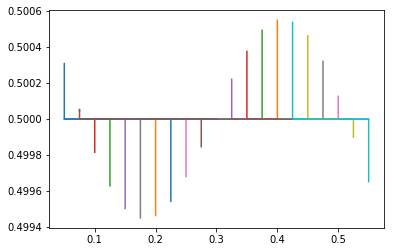

In [54]:
x_ = dict()
y_ = dict()
z_ = dict()
for v in range(1,nop+1):
    x_[v] = np.array([pos[0] for pos in positions_[v]])
    y_[v] = np.array([pos[1] for pos in positions_[v]])
    z_[v] = np.array([pos[2] for pos in positions_[v]])


    
for p in range(1, nop+1):
    plot(x_[p], y_[p])
    

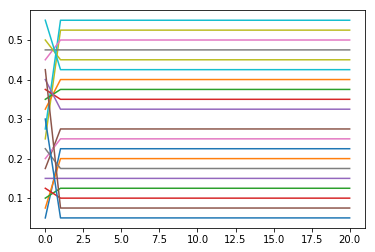

In [55]:
for p in range(1,nop+1):
    plot(x_[p])
   

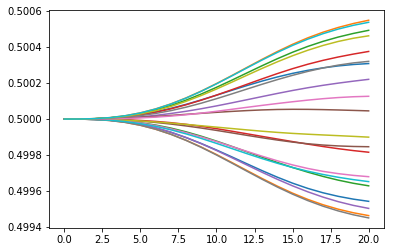

In [56]:
for p in range(1,nop+1):
    plot(y_[p])

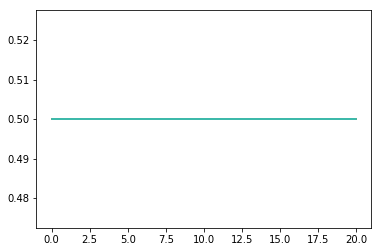

In [57]:
for p in range(1,nop+1):
    plot(z_[p])

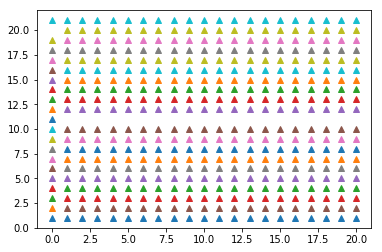

In [58]:
for p in range(1,nop+1):
    plot(id_[p], '^')

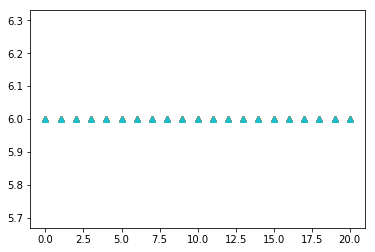

In [59]:
for p in range(1,nop+1):
    plot(cpu_[p], '^')

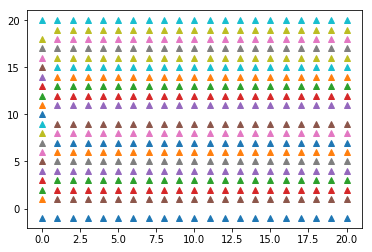

In [60]:
for p in range(1,nop+1):
    plot(id0_[p], '^')

ValueError: setting an array element with a sequence.

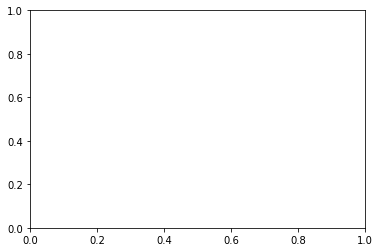

In [61]:
id_sorted_       = dict()
cpu_sorted_      = dict()
position_sorted_ = dict()
marker_id_       = dict()
marker_cpu_      = dict()

x_               = dict()
y_               = dict()
z_               = dict()

marker_posy_ = dict()

m_index = dict()


for x in range(1,nop+1):
    id_sorted_[x]       = list()
    cpu_sorted_[x]      = list()
    position_sorted_[x] = list()
    
    
prevmarker_id  = -1
prevmarker_cpu = -1    

#for data_file in data_files:
#    ds = AMReXDataset(data_file)
#    ad = ds.all_data()

for n in range(1, 10):
    marker_posy_[n] = list()

for n in range(1, 10):
    m = (n-1)*1
    
    data_file = data_files[m]
    #ds = yt.load(data_files[-1])
    ds = AMReXDataset(data_file)
    t = ds.current_time
    ad = ds.all_data()
    aos = AoS(ad)
    prevmarker_id = -1
    prevmarker_cpu = -1
    for k in range(0, nop):
        if aos.particles[k].id_0 == prevmarker_id and aos.particles[k].cpu_0 == prevmarker_cpu:
                id_sorted_[1].append(aos.particles[k].id)
                cpu_sorted_[1].append(aos.particles[k].cpu)
                position_sorted_[1].append(aos.particles[k].pos)
                marker_id_[1] = aos.particles[k].id
                marker_cpu_[1] = aos.particles[k].cpu
                
    for i in range(1,nop):    
        for k in range(0, nop):
            if aos.particles[k].id_0 == marker_id_[i] and aos.particles[k].cpu_0 == marker_cpu_[i]:
                id_sorted_[i+1].append(aos.particles[k].id)
                cpu_sorted_[i+1].append(aos.particles[k].cpu)
                position_sorted_[i+1].append(aos.particles[k].pos)
                marker_id_[i+1] = aos.particles[k].id
                marker_cpu_[i+1] = aos.particles[k].cpu
                
    for v in range(1,nop+1):
        m_index[v] = v
        x_[v] = np.array([pos[0] for pos in position_sorted_[v]])
        y_[v] = np.array([pos[1] for pos in position_sorted_[v]])
        z_[v] = np.array([pos[2] for pos in position_sorted_[v]])
               
        marker_posy_[n].append([pos[1] for pos in position_sorted_[v]])
        
    plot(marker_posy_[n],'-o')  # this is to plot the marker y positions at a given time step to show the flagellum shape
    #import time
    #time.sleep(1.3) 

In [206]:
marker_posy_[1]

[[0.502],
 [0.485],
 [0.475],
 [0.476],
 [0.486],
 [0.5],
 [0.512],
 [0.517],
 [0.512],
 [0.498]]

In [207]:
%matplotlib inline

#print(matplotlib.animation.writers.list())

In [208]:
matplotlib.rcParams['animation.writer'] = 'ffmpeg'
#matplotlib.rcParams['animation.writer'] = 'avconv'

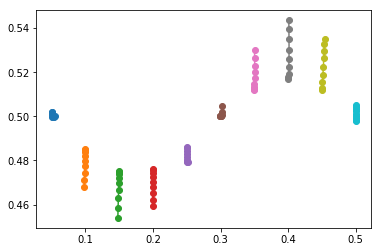

In [209]:
x_                = dict()
y_                = dict()
z_                = dict()


for v in range(1,nop+1):
    x_[v] = np.array([pos[0] for pos in position_sorted_[v]])
    y_[v] = np.array([pos[1] for pos in position_sorted_[v]])
    z_[v] = np.array([pos[2] for pos in position_sorted_[v]])


    
for p in range(1,nop+1):
    plot(x_[p], y_[p], "-o")
    

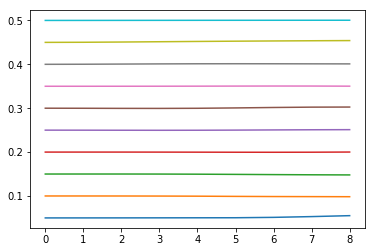

In [210]:
for p in range(1,nop+1):
    plot(x_[p])
   

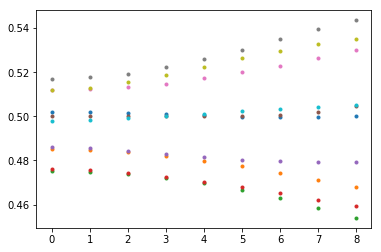

In [211]:
for p in range(1,nop+1):
    plot(y_[p], ".")
   

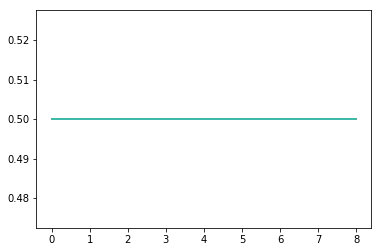

In [212]:
for p in range(1,nop+1):
    plot(z_[p])
   

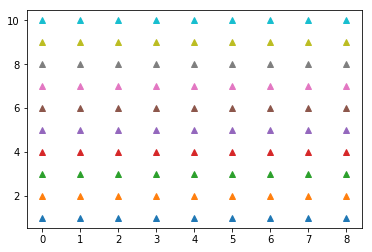

In [213]:
for p in range(1,nop+1):
    plot(id_sorted_[p], '^')

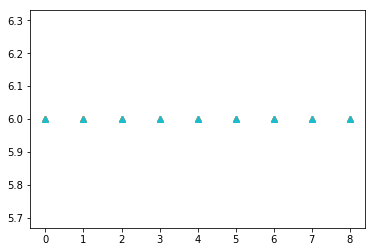

In [214]:
for p in range(1,nop+1):
    plot(cpu_sorted_[p], '^')

## Remove Average `vely`

The $y$-data might seem smooth. But there will be tiny fluctuations. In order to see those, let's compute the average in dimensions 2 and 3.

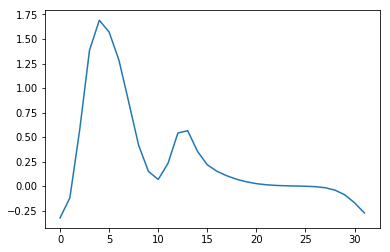

In [215]:
m_vely = mean(mean(vely[:, :, :], axis=1), axis=1)
#              ^^-- returns a 2D array of average velocities
#         ^^------- returns a 1D array of average velocities (the average of the previous average)
plot(m_vely)

Compute fluctuations: `m_vely` is applied to all `dim=1` slices

In [216]:
# slice-wise subtraction of the average velocity... 
# I can't think of a fancy pythonic way of doing this => I'll do it in this cumbersome way:
fluct_vely = np.zeros_like(vely)
for i in range(vely.shape[0]):
    for j in range(vely.shape[1]):
            fluct_vely[:, i, j] = vely[:, i, j] - m_vely[:]

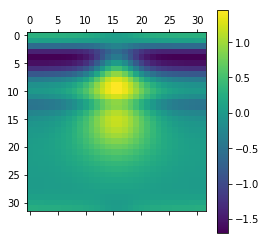

In [217]:
matshow(fluct_vely[:, 8, :])
colorbar()

## Compute $x$, $y$ and $z$ Temperatures (Fluctuations in `velx`, `vely`, `velz`)

In [218]:
t_x = mean(mean(velx[:, :, :]**2, axis=1), axis=1)
#           ^^-- returns a 2D array of average velocities
#      ^^------- returns a 1D array of average velocities (the average of the previous average)
t_x = sqrt(t_x)

In [219]:
t_y = mean(mean(fluct_vely[:, :, :]**2, axis=1), axis=1)
#           ^^-- returns a 2D array of average velocities
#      ^^------- returns a 1D array of average velocities (the average of the previous average)
t_y = sqrt(t_y)

In [220]:
t_z = mean(mean(velz[:, :, :]**2, axis=1), axis=1)
#           ^^-- returns a 2D array of average velocities
#      ^^------- returns a 1D array of average velocities (the average of the previous average)
t_z = sqrt(t_z)

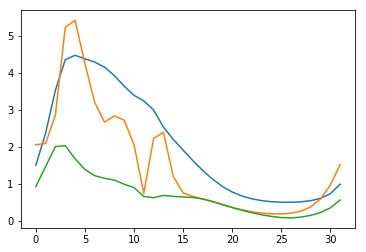

In [221]:
plot(t_x)
plot(t_y)
plot(t_z)

We see that the $x$-fluctuations are supressed due to the wall $\Rightarrow{}$ needs fixing!

# Old Stuff $\Rightarrow{}$ Clean up at some point

In [222]:
def grad(phi):
    dphi_x = np.zeros_like(phi)
    dphi_y = np.zeros_like(phi)
    dphi_z = np.zeros_like(phi)
    
    dphi_x[ :-1, :, :] += phi[1:,   :, :]
    dphi_x[1:,   :, :] -= phi[ :-1, :, :]
    
    dphi_y[:,  :-1, :] += phi[:, 1:,   :]
    dphi_y[:, 1:,   :] -= phi[:,  :-1, :]
    
    dphi_z[:, :,  :-1] += phi[:, :, 1:, ]
    dphi_z[:, :, 1:  ] -= phi[:, :,  :-1]
    
    return dphi_x, dphi_y, dphi_z

In [223]:
grad_x, grad_y, grad_z = grad(cube["con"])

ReferenceError: weakly-referenced object no longer exists

In [ ]:
matshow(cube['con'][32, :, :])

In [ ]:
matshow(grad_z[32, :, 65:])

In [ ]:
matshow(cube['con'][43, :, :])

In [ ]:
matshow(grad_z[43, :, :])

In [ ]:
plot(grad_z[43, 30, :])

In [ ]:
matshow(grad_z[32, :, :])

In [ ]:
matshow(cube['con'][:, :, 45])

In [ ]:
matshow(grad_x[:, :, 45])

In [ ]:
def sphere_coord(i_x, i_y, i_z, dr=dx, r_c=centre_colloid):
    x = (i_x + 0.5)*dr[0] - r_c[0]
    y = (i_y + 0.5)*dr[1] - r_c[1]
    z = (i_z + 0.5)*dr[2] - r_c[2]
    
    r     = np.sqrt( x**2 + y**2 + z**2)
    theta = np.arccos(z/r)
    phi   = np.arctan2(y, x)
        
    return r, theta, phi

def r_unit(theta, phi):
    return np.array([
        np.sin(theta)*np.cos(phi),
        np.sin(theta)*np.sin(phi),
        np.cos(theta)
    ])

def theta_unit(theta, phi):
    return np.array([
        np.cos(theta)*np.cos(phi),
        np.cos(theta)*np.sin(phi),
       -np.sin(theta)
    ])

def phi_unit(phi):
    return np.array([
       -np.sin(phi),
        np.cos(phi),
        0
    ])

In [ ]:
def grad_sphere(grad_x, grad_y, grad_z):
    grad_r     = np.zeros_like(grad_x)
    grad_phi   = np.zeros_like(grad_y)
    grad_theta = np.zeros_like(grad_z)
    
    r_dat     = np.zeros_like(grad_x)
    phi_dat   = np.zeros_like(grad_x)
    theta_dat = np.zeros_like(grad_x)
    
    for ind, x in ndenumerate(grad_x):
        y = grad_y[ind]
        z = grad_z[ind]
        
        r, theta, phi = sphere_coord(ind[0], ind[1], ind[2])
        r_vec     = r_unit(theta, phi)
        theta_vec = theta_unit(theta, phi)
        phi_vec   = phi_unit(phi)
        
        grad_r[ind]     = np.dot(np.array([x, y, z]), r_vec)
        grad_phi[ind]   = np.dot(np.array([x, y, z]), phi_vec)
        grad_theta[ind] = np.dot(np.array([x, y, z]), theta_vec)
        
        r_dat[ind]     = r
        phi_dat[ind]   = phi
        theta_dat[ind] = theta
        
    return np.array(grad_r), np.array(grad_phi), np.array(grad_theta), r_dat, phi_dat, theta_dat

In [ ]:
grad_r, grad_phi, grad_theta, r_dat, phi_dat, theta_dat = grad_sphere(grad_x, grad_y, grad_z)

In [ ]:
matshow(r_dat[32, :, :])

In [ ]:
matshow(phi_dat[32, :, :])

In [ ]:
matshow(theta_dat[32, :, :])

In [ ]:
matshow(grad_norm[43, :, :])

In [ ]:
matshow(grad_phi[45, :, :])

In [ ]:
matshow(grad_theta[45, :, :])

In [ ]:
plot(grad_theta[45, 32, :])
plot(grad_phi[45, 40, :])

In [ ]:
plot(grad_theta[45, 40, :])
plot(grad_phi[45, 40, :])

In [ ]:
matshow(grad_theta[:, :, 60])

In [ ]:
matshow(grad_phi[:, :, 60])

In [ ]:
matshow(cube['con'][:, :, 60])

In [ ]:
matshow(r_dat[:, :, 60])

In [ ]:
matshow(theta_dat[:, :, 60])

In [ ]:
matshow(phi_dat[:, :, 60])

In [ ]:
def scan_theta(r, phi, theta_range, grad_x, grad_y, grad_z, r_c=centre_colloid, dr=dx):
    scan = np.zeros_like(theta_range)
    
    for i, theta in enumerate(theta_range):
        x = r_c[0] + r * np.sin(theta)*np.cos(phi)
        y = r_c[1] + r * np.sin(theta)*np.sin(phi)
        z = r_c[2] + r * np.cos(theta)
                
        i_x = int(x / dx[0])
        i_y = int(y / dx[1])
        i_z = int(z / dx[2])
        
        dphi_x = grad_x[i_x, i_y, i_z]
        dphi_y = grad_y[i_x, i_y, i_z]
        dphi_z = grad_z[i_x, i_y, i_z]
        
        e_theta = theta_unit(theta, phi)
        scan[i] = np.dot(np.array([dphi_x, dphi_y, dphi_z]), -e_theta)
    
    return scan

In [ ]:
x = np.linspace(0, np.pi, num=100)
y_1 = scan_theta(1.4e-3, 0.0, x, grad_x, grad_y, grad_z)
y_2 = scan_theta(1.4e-3, 0.5, x, grad_x, grad_y, grad_z)
y_3 = scan_theta(1.4e-3, 1, x, grad_x, grad_y, grad_z)

In [ ]:
plot(np.pi-x, y_1)
plot(np.pi-x, y_2)
plot(np.pi-x, y_3)

In [ ]:
y

In [ ]:
sel = np.abs(r_dat - 1.1e-3) < 1e-3
sum(sel)

In [ ]:
theta_sel = theta_dat[sel]
phi_sel   = phi_dat[sel]

grad_norm_sel  = grad_norm[sel]
grad_phi_sel   = grad_phi[sel]
grad_theta_sel = grad_theta[sel]

In [ ]:
phi_selector = np.abs(phi_sel - 0.6) < 1e-3
sum(phi_selector)

In [ ]:
sorted_pts = np.array(sorted(zip(theta_sel[phi_selector], grad_theta_sel[phi_selector])))

In [ ]:
plot(sorted_pts[:,0], sorted_pts[:,1])

In [ ]:
plot(theta_sel[:100])